In [1]:
import numpy as np
from scipy.signal import lfilter, firwin
from pylab import *
from scipy.fftpack import fft,fftshift
import scipy.signal as signal
from tool._fixedInt import *

# Creacion de señal 

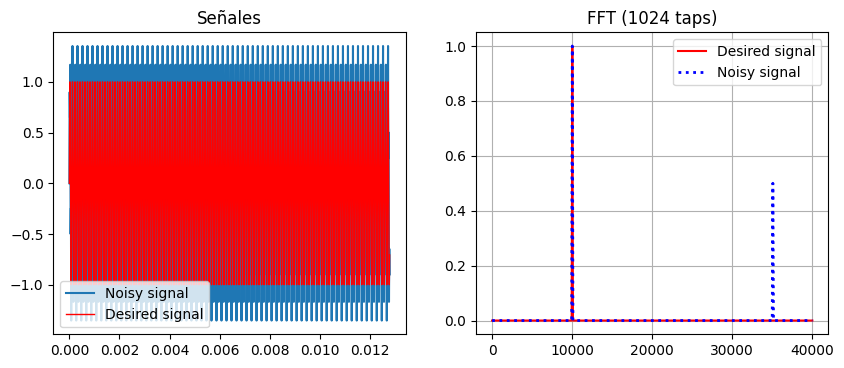

In [8]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------
# 320 samples of (1000Hz + 15000 Hz) at 48 kHz

sample_rate = 80000.
nsamples = 1024

f1 = 10000.
A1 = 1.0
 
f2 = 35000.
A2 = 0.5
 
t = np.arange(nsamples) / sample_rate

desired      = A1 * np.sin(2*np.pi*f1*t)
noise        = A2 * np.sin(2*np.pi*f2*t)
noisy_signal = desired + noise
 

# FFT
NFFT = 1024
fs = sample_rate

fft_desired_signal = fft(desired,NFFT)
fft_noisy_signal   = fft(noisy_signal,NFFT)
xfft               = np.linspace(0.0, 1.0/(2.0*t[1]), NFFT//2)

#------------------------------------------------
# Plot signals
#------------------------------------------------
plt.figure(1, figsize=(10,4), dpi=100)
plt.subplot(1,2,1)
plt.title("Señales")
plt.plot(t, noisy_signal, label='Noisy signal')
plt.plot(t, desired, 'r-', linewidth=1, label='Desired signal')
plt.legend()

# FFT PLOT
plt.subplot(1,2,2)
plt.plot(xfft,2.0/NFFT * np.abs(fft_desired_signal[0:NFFT//2]),'r-', label='Desired signal')
plt.plot(xfft,2.0/NFFT * np.abs(fft_noisy_signal[0:NFFT//2]),'b:' ,linewidth=2, label='Noisy signal')
title('FFT (%d taps)' % NFFT)
legend()
grid(True)
show()

# Diseño del filtro FIR  ($f_{cut}$ y $N_{taps}$)

Coeficientes del filtro: [0.03857901 0.46142099 0.46142099 0.03857901]


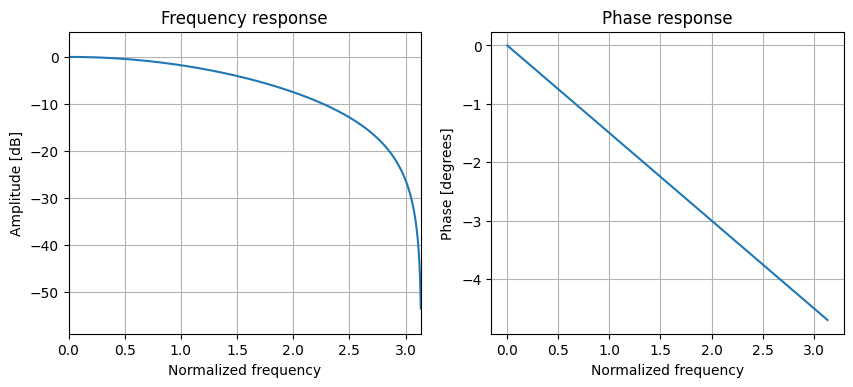

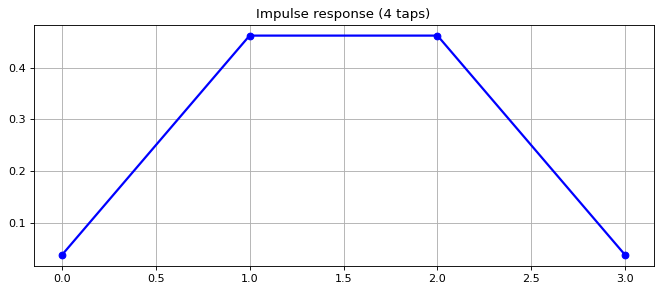

In [9]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.
 
# The cutoff frequency of the filter: 8KHz
cutoff_hz = 10000.0
 
# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 4
 
# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)
print(f"Coeficientes del filtro: {fir_coeff}")
    
# Use lfilter to filter the signal with the FIR filter
filtered_signal = lfilter(fir_coeff, 1.0, noisy_signal)

# FFT
fft_filtered_signal = fft(filtered_signal,NFFT)


# Filter Response
w, h = signal.freqz(fir_coeff)

plt.figure(1, figsize=(10,4), dpi=100)

plt.subplot(1,2,1)
plt.title('Frequency response')
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(True, color = '0.7', linestyle='-', which='major', axis='both')
plt.grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
plt.plot(w, 20*log10(abs(h)))

plt.subplot(1,2,2)
plt.title('Phase response')
plt.xlabel('Normalized frequency')
plt.ylabel('Phase [degrees]')
plt.grid(True, color = '0.7', linestyle='-', which='major')
plt.grid(True, color = '0.9', linestyle='-', which='minor')
plt.plot(w, unwrap(angle(h)))

plt.show()


#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
plt.figure(1, figsize=(10, 4), dpi=80)
plt.plot(fir_coeff, 'bo-', linewidth=2)
plt.title('Impulse response (%d taps)' % numtaps)
plt.grid(True)

# Grafico de señal original vs señal filtrada

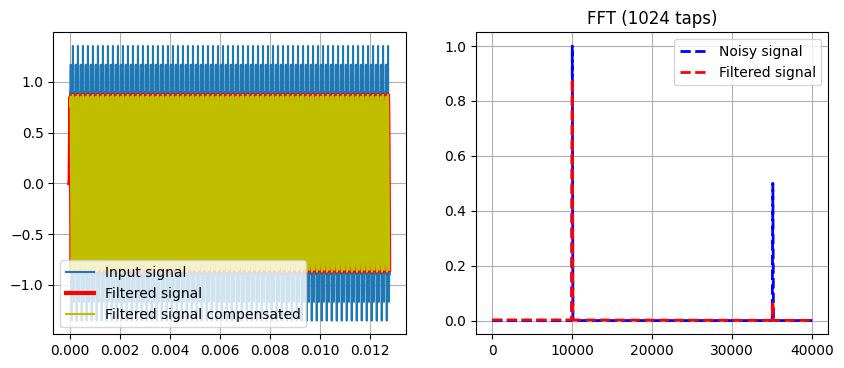

In [10]:

 
# The first N-1 samples are "corrupted" by the initial conditions
warmup = numtaps - 1
 
# The phase delay of the filtered signal
delay = (warmup / 2) / sample_rate
 
plt.figure(1, figsize=(10, 4), dpi=100)
# Plot the original signal
plt.subplot(1,2,1)
plt.plot(t, noisy_signal, label='Input signal')
# Plot the filtered signal, shifted to compensate for the phase delay
plt.plot(t-delay, filtered_signal, 'r-', linewidth=3 , label='Filtered signal')
# Plot just the "good" part of the filtered signal.  The first N-1 samples are "corrupted" by the I.C.
plt.plot(t[warmup:]-delay, filtered_signal[warmup:], 'y', label='Filtered signal compensated')

plt.legend()
plt.grid(True)


# FFT PLOT
plt.subplot(1,2,2)
plt.title('FFT (%d taps)' % NFFT)
plt.plot(xfft,2.0/NFFT * np.abs(fft_noisy_signal[0:NFFT//2]),'--b' ,linewidth=2, label='Noisy signal')
plt.plot(xfft,2.0/NFFT * np.abs(fft_filtered_signal[0:NFFT//2]),'--r' ,linewidth=2, label='Filtered signal')
plt.legend()
plt.grid(True)

show()

# Definición de numero de bits de los coeficientes del filtro

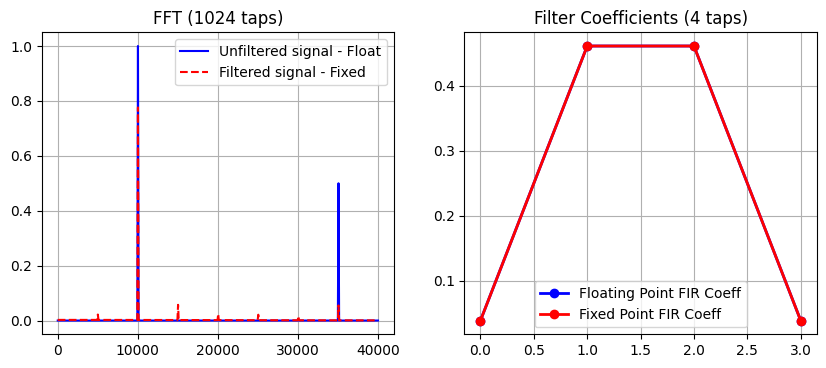

In [11]:
def fir_filter(x,c):
    Xn_Coeff = x * c
    fp_acumulador = Xn_Coeff[0]
    for index in range(1,len(Xn_Coeff)):
        fp_acumulador =  fp_acumulador + Xn_Coeff[index]
    return fp_acumulador

# =======================================
# =======================================
NB_COEF_TOTAL      = 16
NB_COEF_FRACCIONAL = 15

NB_DATA_TOTAL      = 16
NB_DATA_FRACCIONAL = 15
# =======================================
# =======================================


taps= len(fir_coeff)
init_coeff = np.ones(taps)

coeff = arrayFixedInt(NB_COEF_TOTAL, NB_COEF_FRACCIONAL,fir_coeff)
xn =  arrayFixedInt(NB_DATA_TOTAL, NB_DATA_FRACCIONAL,init_coeff)

value_coeff = [a.fValue for a in coeff]

fp_filtered = []
temp = [0.0]*taps

for value in noisy_signal:
    temp.insert(0,value)
    temp.pop()
    for j in range(taps):
        xn[j].value = temp[j]
    Yn = fir_filter(xn,coeff)
    fp_filtered.append(Yn.fValue)
    
fft_filtered_signal = fft(fp_filtered,NFFT)

# Filter Response
w, h = signal.freqz(value_coeff)


# FFT PLOT
plt.figure(2, figsize=(10, 4), dpi=100)
plt.subplot(1,2,1)
plt.title('FFT (%d taps)' % NFFT)
plt.plot(xfft,2.0/NFFT * np.abs(fft_noisy_signal[0:NFFT//2]),'b-', label='Unfiltered signal - Float')
plt.plot(xfft,2.0/NFFT * np.abs(fft_filtered_signal[0:NFFT//2]),'--r' ,linewidth=1.5, label='Filtered signal - Fixed')
plt.legend()
plt.grid(True)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
plt.subplot(1,2,2)
plt.plot(fir_coeff, 'bo-', linewidth=2, label='Floating Point FIR Coeff')
plt.plot(value_coeff, 'ro-', linewidth=2, label='Fixed Point FIR Coeff')
plt.title('Filter Coefficients (%d taps)' % numtaps)

plt.legend()
plt.grid(True)
plt.show()


# Coeficientes del filtro en floating point y hexadecimal

In [12]:
print(f"Coeficientes del filtro:\n {fir_coeff}")

Coeficientes del filtro:
 [0.03857901 0.46142099 0.46142099 0.03857901]


In [13]:
print("Coeficientes en hexadecimal para insertar en el .v")
for a in coeff:
    print(a.__hex__())


Coeficientes en hexadecimal para insertar en el .v
0x04F0
0x3B0F
0x3B0F
0x04F0
